In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from sklearn.pipeline import Pipeline as SklearnPipeline # Renamed to avoid conflict
from imblearn.pipeline import Pipeline as ImbPipeline # For pipelines with SMOTE
from imblearn.over_sampling import SMOTE
import joblib
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

# Plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("pastel")

In [22]:
# Assuming the notebook is in 'notebooks/' and data in 'data/raw/'
try:
    df_raw = pd.read_csv("../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    df = df_raw.copy() # Work on a copy
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'WA_Fn-UseC_-HR-Employee-Attrition.csv' not found. Check path.")
    df = pd.DataFrame() # Create empty df to avoid further errors in notebook

print("Shape of the dataset:", df.shape)
df.head()

Data loaded successfully!
Shape of the dataset: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [23]:
if not df.empty:
    print("\n--- Data Info ---")
    df.info()

    print("\n--- Descriptive Statistics (Numerical) ---")
    print(df.describe())

    print("\n--- Descriptive Statistics (Categorical) ---")
    print(df.describe(include="object"))

    print("\n--- Missing Values ---")
    print(df.isnull().sum())

    print("\n--- Duplicate Rows ---")
    print("Number of duplicate rows:", df.duplicated().sum())
    # df.drop_duplicates(inplace=True) # If duplicates were found and deemed appropriate to drop

    print("\n--- Target Variable Distribution (Attrition) ---")
    if 'Attrition' in df.columns:
        print(df["Attrition"].value_counts())
        print(df["Attrition"].value_counts(normalize=True) * 100)
    else:
        print("'Attrition' column not found.")
else:
    print("DataFrame is empty. Skipping detailed exploration.")


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLe

In [25]:
if not df.empty and 'Attrition' in df.columns:
    # 1. Drop unnecessary columns (often unique identifiers or constant columns)
    # Based on common knowledge of this dataset:
    cols_to_drop = ["EmployeeCount", "EmployeeNumber", "StandardHours", "Over18"]
    # Check if columns exist before dropping
    existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    df.drop(columns=existing_cols_to_drop, inplace=True, errors='ignore')
    print(f"Dropped columns: {existing_cols_to_drop}")

    # 2. Map target variable 'Attrition' to numerical
    df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})
    print("\n'Attrition' column mapped to 0/1.")

    # 3. Identify categorical and numerical features
    numerical_features = df.select_dtypes(include=np.number).columns.tolist()
    # Remove target from numerical features if it's there
    if 'Attrition' in numerical_features:
        numerical_features.remove("Attrition")

    categorical_features = df.select_dtypes(include="object").columns.tolist()

    import joblib
    # Make sure paths are relative to the notebook's location if it's in 'notebooks/'
    numerical_features_path = "../models/numerical_features_v1.joblib"
    categorical_features_path = "../models/categorical_features_v1.joblib"

    joblib.dump(numerical_features, numerical_features_path)
    joblib.dump(categorical_features, categorical_features_path)

    print(f"Numerical features list saved to: {numerical_features_path}")
    print(f"Categorical features list saved to: {categorical_features_path}")


    print(f"\nNumerical Features: {numerical_features}")
    print(f"Categorical Features: {categorical_features}")

    # At this stage, the `df` is partially preprocessed.
    # One-hot encoding and scaling will be done within the pipeline.
else:
    print("DataFrame is empty or 'Attrition' column missing. Skipping preprocessing.")

# Save a copy of the cleaned (but not yet encoded/scaled) data
if not df.empty:
    df.to_csv("../data/processed/cleaned_exploratory_data.csv", index=False)
    print("\nCleaned exploratory data saved to 'data/processed/cleaned_exploratory_data.csv'")

Dropped columns: []

'Attrition' column mapped to 0/1.
Numerical features list saved to: ../models/numerical_features_v1.joblib
Categorical features list saved to: ../models/categorical_features_v1.joblib

Numerical Features: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical Features: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

Cleaned exploratory data saved to 'data/processed/cleaned_exploratory_data.csv'


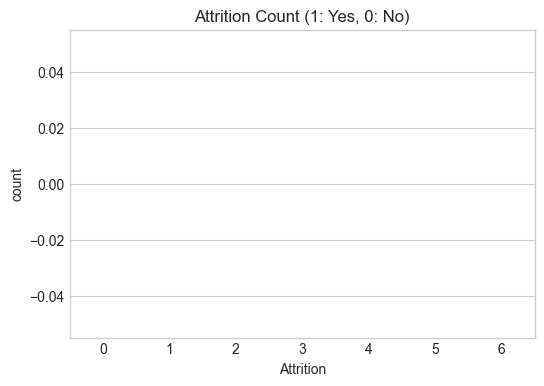

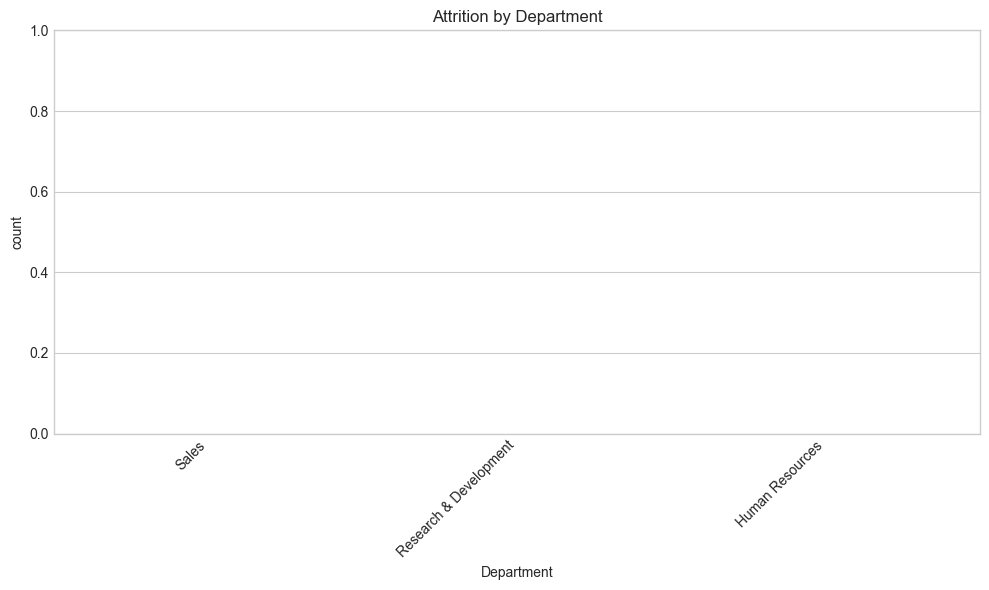

ValueError: List of boxplot statistics and `positions` values must have same the length

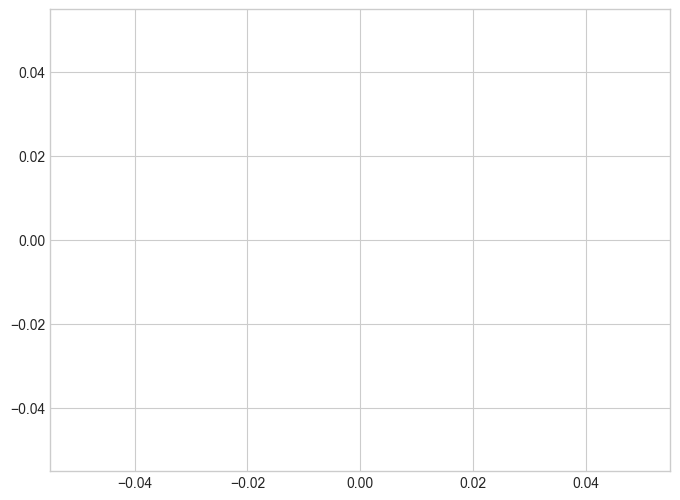

In [26]:
if not df.empty and 'Attrition' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x="Attrition", data=df)
    plt.title("Attrition Count (1: Yes, 0: No)")
    plt.show()

    # Example: Attrition by Department
    if 'Department' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x="Department", hue="Attrition", data=df)
        plt.title("Attrition by Department")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # Example: Monthly Income by Attrition
    if 'MonthlyIncome' in df.columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x="Attrition", y="MonthlyIncome", data=df)
        plt.title("Monthly Income by Attrition")
        plt.show()

    # Example: Correlation Heatmap for numerical features
    if numerical_features: # Check if list is not empty
        plt.figure(figsize=(18, 15))
        correlation_matrix = df[numerical_features + ['Attrition']].corr() # Include target
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
        plt.title("Correlation Matrix of Numerical Features (and Attrition)")
        plt.show()
else:
    print("DataFrame empty or 'Attrition' missing. Skipping EDA plots.")

In [27]:
if not df.empty and 'Attrition' in df.columns:
    X = df.drop("Attrition", axis=1)
    y = df["Attrition"]

    # Update numerical and categorical feature lists after potential drops
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include="object").columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y # Stratify by target
    )
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train distribution:\n", y_train.value_counts(normalize=True))
    print("y_test distribution:\n", y_test.value_counts(normalize=True))
else:
    print("DataFrame empty or 'Attrition' missing. Skipping model preparation.")

ValueError: Input y contains NaN.

In [ ]:
if 'X_train' in locals(): # Check if X_train exists
    # Create preprocessor
    # Numerical features: Standard scaling
    # Categorical features: One-hot encoding
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="first") # drop='first' to avoid multicollinearity

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # --- Define Models ---
    # 1. Logistic Regression
    logreg_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)), # Handle imbalance
        ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
    ])

    # 2. Random Forest
    rf_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
    ])

    # (Optional) Add other models like SVC, KNN, GaussianNB if desired
    # svc_pipeline = ImbPipeline(...)
    # knn_pipeline = ImbPipeline(...)
    # nb_pipeline = ImbPipeline(...) # GaussianNB doesn't usually need SMOTE as much or class_weight

    models = {
        "Logistic Regression": logreg_pipeline,
        "Random Forest": rf_pipeline,
    }

    # --- Train and Evaluate Models ---
    results = {}

    for model_name, model_pipeline in models.items():
        print(f"--- Training {model_name} ---")
        model_pipeline.fit(X_train, y_train)
        y_pred = model_pipeline.predict(X_test)
        y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probability of class 1

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=1) # Focus on 'Yes' (1)
        recall = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        results[model_name] = {
            "Accuracy": accuracy,
            "Precision (Attrition=Yes)": precision,
            "Recall (Attrition=Yes)": recall,
            "F1-score (Attrition=Yes)": f1,
            "ROC AUC": roc_auc,
            "Confusion Matrix": confusion_matrix(y_test, y_pred),
            "Classification Report": classification_report(y_test, y_pred),
        }
        print(f"Results for {model_name}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision (Yes): {precision:.4f}")
        print(f"  Recall (Yes): {recall:.4f}")
        print(f"  F1-score (Yes): {f1:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}\n")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        print("-" * 50)

    results_df = pd.DataFrame(results).T # Transpose for better readability
    print("\n--- Summary of Model Results ---")
    print(results_df[["Accuracy", "Precision (Attrition=Yes)", "Recall (Attrition=Yes)", "F1-score (Attrition=Yes)", "ROC AUC"]])

else:
    print("X_train not defined. Skipping model training.")

--- Training Logistic Regression ---
Results for Logistic Regression:
  Accuracy: 0.7853
  Precision (Yes): 0.3958
  Recall (Yes): 0.6441
  F1-score (Yes): 0.4903
  ROC AUC: 0.8014

Confusion Matrix:
 [[251  58]
 [ 21  38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86       309
           1       0.40      0.64      0.49        59

    accuracy                           0.79       368
   macro avg       0.66      0.73      0.68       368
weighted avg       0.84      0.79      0.80       368

--------------------------------------------------
--- Training Random Forest ---
Results for Random Forest:
  Accuracy: 0.8533
  Precision (Yes): 0.6190
  Recall (Yes): 0.2203
  F1-score (Yes): 0.3250
  ROC AUC: 0.7803

Confusion Matrix:
 [[301   8]
 [ 46  13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       309
           1       0.62    

In [28]:
if 'rf_pipeline' in locals() and 'X_train' in locals():
    print("\n--- Hyperparameter Tuning for Random Forest ---")
    # Define parameter grid - adjust based on initial RF performance and time
    # Note: 'classifier__' prefix is needed because 'classifier' is the name of the RF step in the ImbPipeline
    param_grid_rf = {
        'classifier__n_estimators': [100, 200], # Number of trees
        'classifier__max_depth': [10, 20, None], # Max depth of trees
        'classifier__min_samples_split': [2, 5], # Min samples to split a node
        'classifier__min_samples_leaf': [1, 2],  # Min samples at a leaf node
        # 'smote__k_neighbors': [3, 5, 7] # If you want to tune SMOTE params too
    }

    # Use F1-score for the positive class (Attrition=Yes) as the scoring metric
    # The pipeline already handles preprocessing and SMOTE, so GridSearchCV works on the full pipeline
    grid_search_rf = GridSearchCV(
        estimator=rf_pipeline,
        param_grid=param_grid_rf,
        cv=3, # 3-fold cross-validation (use 5 for more robust)
        scoring='f1', # F1 for the positive class (implicitly, if binary)
        # Or scoring=make_scorer(f1_score, pos_label=1) for explicit control
        verbose=1,
        n_jobs=-1 # Use all available cores
    )

    grid_search_rf.fit(X_train, y_train)

    print("\nBest Parameters for Random Forest:", grid_search_rf.best_params_)
    best_rf_model = grid_search_rf.best_estimator_ # This is the fully trained pipeline with best params

    # Evaluate the best model from GridSearchCV
    y_pred_best_rf = best_rf_model.predict(X_test)
    y_pred_proba_best_rf = best_rf_model.predict_proba(X_test)[:, 1]

    print("\n--- Performance of Tuned Random Forest ---")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
    print(f"  Precision (Yes): {precision_score(y_test, y_pred_best_rf, pos_label=1):.4f}")
    print(f"  Recall (Yes): {recall_score(y_test, y_pred_best_rf, pos_label=1):.4f}")
    print(f"  F1-score (Yes): {f1_score(y_test, y_pred_best_rf, pos_label=1):.4f}")
    print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba_best_rf):.4f}\n")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))
    print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))

    # This best_rf_model is what you'd save for the Streamlit app
else:
    print("Random Forest pipeline or X_train not defined. Skipping hyperparameter tuning.")


--- Hyperparameter Tuning for Random Forest ---
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters for Random Forest: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

--- Performance of Tuned Random Forest ---
  Accuracy: 0.8505
  Precision (Yes): 0.5769
  Recall (Yes): 0.2542
  F1-score (Yes): 0.3529
  ROC AUC: 0.7630

Confusion Matrix:
 [[298  11]
 [ 44  15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92       309
           1       0.58      0.25      0.35        59

    accuracy                           0.85       368
   macro avg       0.72      0.61      0.63       368
weighted avg       0.82      0.85      0.83       368




--- Feature Importance Analysis (Tuned Random Forest) ---

Top 20 Important Features:
                              feature  importance
43                       OverTime_Yes    0.112215
15                   StockOptionLevel    0.058752
22               YearsWithCurrManager    0.050630
19                     YearsAtCompany    0.041152
42               MaritalStatus_Single    0.039178
0                                 Age    0.034753
9                       MonthlyIncome    0.034482
18                    WorkLifeBalance    0.030505
7                            JobLevel    0.030263
8                     JobSatisfaction    0.029884
11                 NumCompaniesWorked    0.029324
16                  TotalWorkingYears    0.028904
41              MaritalStatus_Married    0.027953
20                 YearsInCurrentRole    0.026377
4             EnvironmentSatisfaction    0.026034
14           RelationshipSatisfaction    0.025310
1                           DailyRate    0.024766
2            

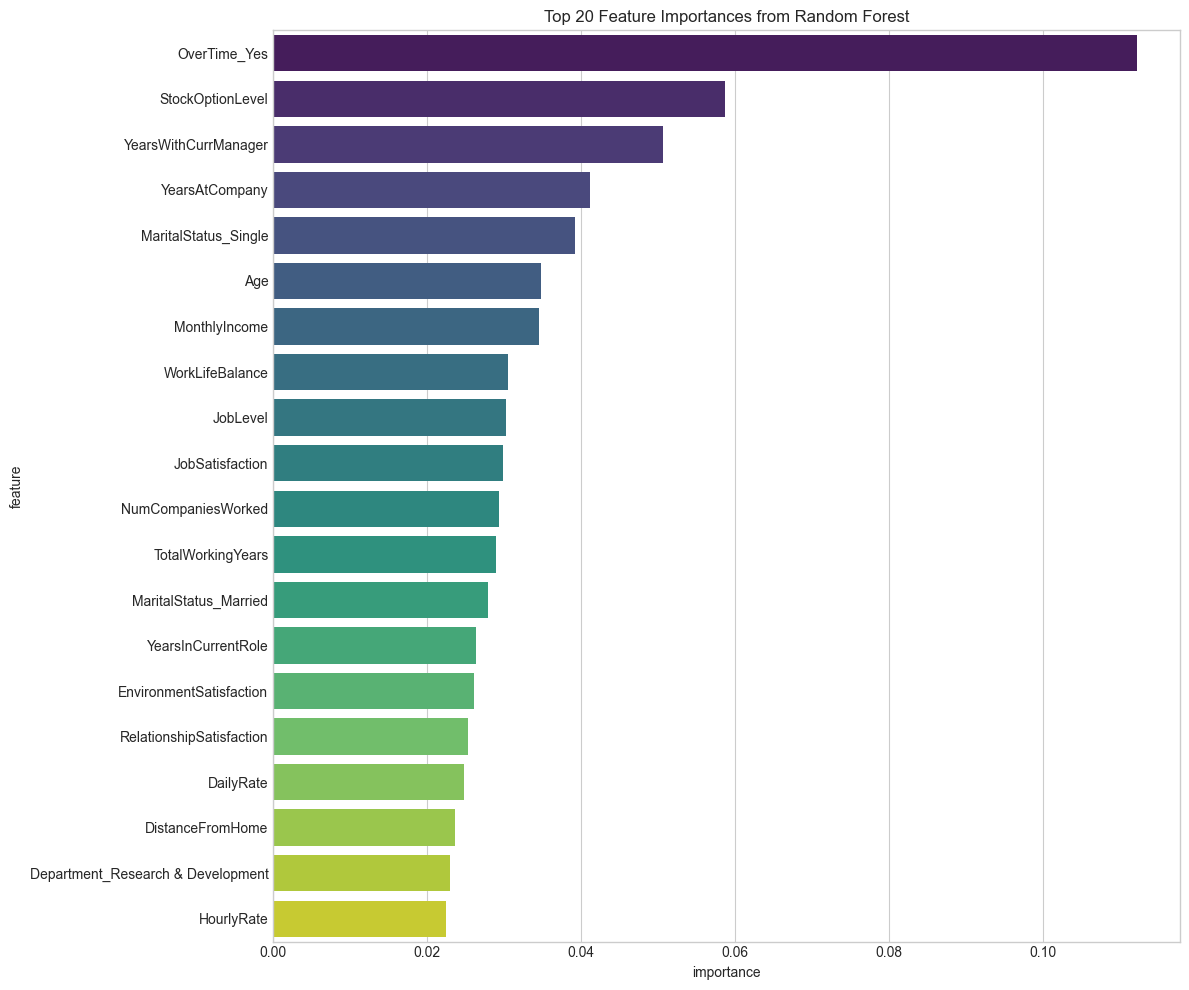

In [29]:
if 'best_rf_model' in locals():
    print("\n--- Feature Importance Analysis (Tuned Random Forest) ---")
    # Get the preprocessor step from the best model pipeline
    preprocessor_step = best_rf_model.named_steps['preprocessor']
    # Get the classifier step
    classifier_step = best_rf_model.named_steps['classifier']

    # Get feature names after one-hot encoding from the preprocessor
    # 'cat' is the name of the OneHotEncoder transformer in our ColumnTransformer
    try:
        ohe_feature_names = preprocessor_step.transformers_[1][1].get_feature_names_out(categorical_features)
        # The [1] accesses the categorical transformer part of ColumnTransformer
        # The second [1] accesses the OneHotEncoder itself.
    except AttributeError:
        # For older scikit-learn versions, get_feature_names_out might not exist for the ColumnTransformer directly
        # or the OneHotEncoder. This is a common point of version incompatibility.
        # Fallback (might not be perfect, assumes one-hot encoder is the second transformer)
        ohe_transformer = preprocessor_step.named_transformers_['cat']
        ohe_feature_names = ohe_transformer.get_feature_names_out(input_features=categorical_features)


    # Combine numerical feature names and OHE feature names
    # Ensure numerical_features is defined correctly based on X_train columns
    final_feature_names = numerical_features + list(ohe_feature_names)


    importances = classifier_step.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': final_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print("\nTop 20 Important Features:")
    print(feature_importance_df.head(20))

    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette="viridis")
    plt.title('Top 20 Feature Importances from Random Forest')
    plt.tight_layout()
    plt.show()
else:
    print("Best Random Forest model not defined. Skipping feature importance analysis.")

In [30]:
if 'best_rf_model' in locals():
    # Save the entire pipeline (preprocessor + SMOTE + classifier)
    model_save_path = "../models/attrition_rf_pipeline_v1.joblib"
    joblib.dump(best_rf_model, model_save_path)
    print(f"\nBest Random Forest pipeline saved to: {model_save_path}")

    # Also save the original columns of X_train, as the pipeline expects them in this order
    # (Though the ColumnTransformer inside the pipeline handles selection by name)
    # For sanity checking or if manually creating input DataFrame for Streamlit later
    X_train_columns_path = "../models/X_train_columns_v1.joblib"
    joblib.dump(X_train.columns.tolist(), X_train_columns_path)
    print(f"X_train column order saved to: {X_train_columns_path}")
else:
    print("Best Random Forest model not defined. Skipping model saving.")


Best Random Forest pipeline saved to: ../models/attrition_rf_pipeline_v1.joblib
X_train column order saved to: ../models/X_train_columns_v1.joblib


In [31]:
print("\n--- End of Notebook ---")


--- End of Notebook ---
